Tabular Q learning

In [73]:
# Import env
import gym, gym_unbalanced_disk, time

#env = gym.make('unbalanced-disk-v0', dt=0.025, umax=3.) 
#env = gym_unbalanced_disk.UnbalancedDisk(dt=0.025, umax=3.) #alternative # so the step is in 

# env = gym_unbalanced_disk.UnbalancedDisk_sincos(dt=0.025, umax=3.)  # sincos to describe angle range:(-1,1)

# obs = env.reset()
# try:
#     for i in range(200):
#         obs, reward, done, info = env.step(env.action_space.sample()) #random action
#         print(obs,reward)
#         env.render()
#         time.sleep(1/24)
#         if done:
#             obs = env.reset()
# finally: #this will always run
#     env.close()

Discrete wrapper

In [74]:
import numpy as np
from gym import spaces

class DiscretizeWrapper(gym.Wrapper):
    def __init__(self, env,num_obs=[50,50,40],num_act=10): # three state(sin(angle),cos(angle),angular velocity), 1 input(voltage)
        super().__init__(env)
        self.num_obs=np.array(num_obs)
        self.num_act=np.array(num_act)
        # define new spaces
        self.observation_space = spaces.MultiDiscrete(self.num_obs)
        self.action_space = spaces.Discrete(self.num_act)

        self.olow, self.ohigh = env.observation_space.low, env.observation_space.high
        self.alow, self.ahigh = env.action_space.low, env.action_space.high
        #print(self.olow,self.ohigh) #[ -1.  -1. -40.] [ 1.  1. 40.]
        #print(self.alow, self.ahigh ) # -3.0 3.0

        # action discrete list.
        self.stepsize = (self.ahigh-self.alow)/self.num_act
        self.values_list = np.arange(self.alow,self.ahigh,self.stepsize)

    def discretize_obs(self,observation):
        #scale_obs = (observation-self.olow)/(self.ohigh-self.olow)
        #mid=((scale_obs*self.num_obs))#.astype(int)       
        step = (self.ohigh-self.olow)/self.num_obs
    
        values_list_1 = np.arange(self.olow[0],self.ohigh[0],step[0])
        values_list_2 = np.arange(self.olow[1],self.ohigh[1],step[1])
        values_list_3 = np.arange(self.olow[2],self.ohigh[2],step[2])
        #print(values_list_3)

        out_1 = round(values_list_1[np.abs(values_list_1-observation[0]).argmin()],4) # obs-list the min one is the closet value, so choose it index and find it
        out_2 = round(values_list_2[np.abs(values_list_2-observation[1]).argmin()],4)
        out_3 = round(values_list_3[np.abs(values_list_3-observation[2]).argmin()],4)
        return  tuple([out_1,out_2,out_3])
    
    def discretize_act(self,action):
        #scale_act = (action-self.alow)/(self.ahigh-self.alow)
        #mid = ((scale_act*self.num_act))#.astype(int)
        stepsize = (self.ahigh-self.alow)/self.num_act
        values_list = np.arange(self.alow,self.ahigh,stepsize)
        out = values_list[np.abs(values_list-action).argmin()] 
        return round(out,4)


    def step(self,action):
        action_discretized = self.discretize_act(action)
        #print(action_disretized)
        observation, reward, done, info = self.env.step(action_discretized)
        #print(observation)
        observation_discretized = self.discretize_obs(observation)
        return observation_discretized,reward,done,info

    def reset(self):
        return self.discretize_obs(self.env.reset()) # casue reset return obs
    


In [75]:
# env_new = gym.wrappers.time_limit.TimeLimit(env,max_episode_steps=3000)
# env_new = DiscretizeWrapper(env_new,num_obs=[100,100,640],num_act=300)
# env_new.reset()

# print(env_new.step(0))
# print(env_new.step(0))
# print(env_new.step(0)) 
# print(env_new.step(0))
# print(env_new.step(1))
# print(env_new.step(1))
# print(env_new.step(2))

Q learning structure

In [76]:
def argmax(a):
    #random argmax
    a = np.array(a)
    return np.random.choice(np.arange(len(a),dtype=int)[a==np.max(a)])   # return index

def roll_mean(ar,start=2000,N=50): #smoothing if needed
    s = 1-1/N
    k = start
    out = np.zeros(ar.shape)
    for i,a in enumerate(ar):
        k = s*k + (1-s)*a
        out[i] = k
    return out



##########

def Qlearn_tab(env_new,env_old,nsteps=8000,callbackfreq=100,alpha=0.2,eps=0.2,gamma=0.75):
    from collections import defaultdict
    Qmat = defaultdict(float)
    episode_lengths =[]
    episode_len_steps=[]
    obs_record=[]
    step_count=[]
    reward_record=[]

    obs = env_new.reset()  # already discretized  like (0.0, 0.98, 0.0)
    print('Goal reached time:')
    count = 0
    for z in range(nsteps):
        if np.random.uniform()<eps:
            action = env_new.discretize_act(env_old.action_space.sample()) # need discrete action space
        else:
            action = env_new.values_list[argmax([Qmat[obs,i] for i in env_new.values_list])] # -3.0,-2.98,...3 #convert to list for len
        
        obs_new, reward, done, info = env_new.step(action) ##input action have used discreted value, step will do action discrete again, double discrete, but fine.
        count+=1

        if done and not info.get('TimeLimit.truncated',False): # finish, done and time didn't out
            # save
            print(env_new._elapsed_steps,end=' ')
            # episode_lengths.append(env_new._elapsed_steps)
            # episode_len_steps.append(z)

            # update Q tabular
            TD = reward - Qmat[obs,action] # TD
            Qmat[obs,action]+=alpha*TD
            obs=env_new.reset()
            print('goal reached')
            

        else:  # before done,   time out or not
            #next_action = env_new.values_list[argmax([Qmat[obs_new, i] for i in env_new.values_list])]
            TD = reward + gamma*max(Qmat[obs_new,i] for i in env_new.values_list) -Qmat[obs,action]
            Qmat[obs,action]+=alpha*TD
            obs = obs_new

            if count % callbackfreq ==0:
                obs_record.append(obs)
                step_count.append(count)
                reward_record.append(reward)

            if info.get('TimeLimit.truncated',False):
                # save 
                # episode_lengths.append(env_new._elapsed_steps)
                # episode_len_steps.append(z)
                print('out',end=' ')

                obs = env_new.reset()
    print()
    return Qmat,np.array(obs_record),np.array(step_count),np.array(reward_record) #np.array(episode_lengths),np.array(episode_len_steps)





In [77]:
from matplotlib import pyplot as plt   # 循环的方式要修改！不需要得到out和时间，看角度和速度！
env = gym_unbalanced_disk.UnbalancedDisk_sincos(dt=0.025, umax=3.)          
#for num_act in [100,140,180,220,240,260,280,300]: # Firstly only test action
num_act=20
env_new = DiscretizeWrapper(env,num_obs=[10,10,80],num_act=num_act)
env_new = gym.wrappers.time_limit.TimeLimit(env_new,max_episode_steps=100_000)
print('num_act=',num_act)
#Qmat, ep_lengths_steps, ep_lengths = Qlearn_tab(env_new=env_new,env_old=env, nsteps=400_000)
Qmat,obs_record,step_count,reward_record = Qlearn_tab(env_new=env_new,env_old=env, nsteps=500_000)


#plt.plot(ep_lengths_steps,roll_mean(ep_lengths,start=3000),label=str(num_act)) #c)   总步骤数量一样，为什么有的print的多，有的少？？

#plt.legend()
#plt.show()

# Big notice, env UnbalancedDisk  setp will always output False, means  done is always False , cause, it dosen't reach the goal at all!


num_act= 20
Goal reached time:
out out out out out 


Visualization

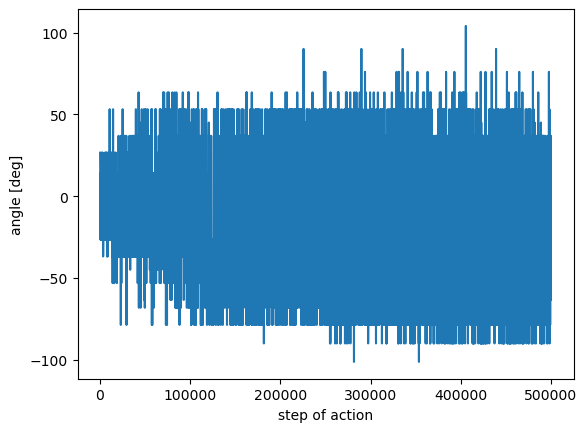

In [78]:
angle_deg=np.degrees(np.arctan2(obs_record[:,0],obs_record[:,1])) # (sin,cos)
plt.plot(step_count,angle_deg)
plt.xlabel('step of action')
plt.ylabel('angle [deg]')
plt.show()

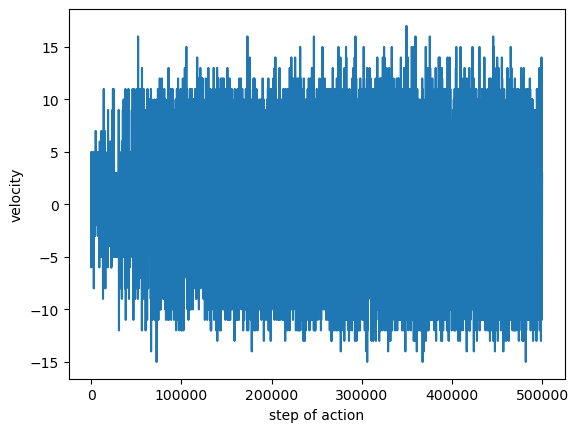

In [79]:
plt.plot(step_count,obs_record[:,2])
plt.xlabel('step of action')
plt.ylabel('velocity')
plt.show()

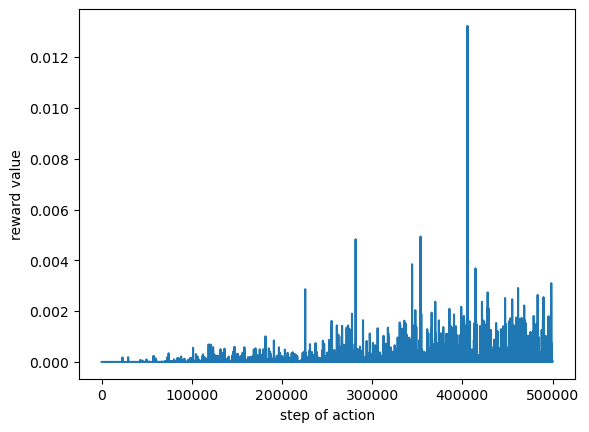

In [80]:
plt.plot(step_count,reward_record[:])
plt.xlabel('step of action')
plt.ylabel('reward value')
plt.show()

In [81]:
obs = env_new.reset()  # 
try:                   # 既然没法通过goal reach time来看出哪个更好，明显我们需要看数据！每隔一段时间打印state，而不是看流逝的时间！！ print state ,done
    env_new.render()    
    done= False
    while done==False:
        action = env_new.values_list[argmax([Qmat[obs,i] for i in env_new.values_list])]
        obs, reward, done, info = env_new.step(action)
        env.render()
        time.sleep(1/60)
        print(obs,reward,action,done,info)
finally:
    env_new.close()

(-0.0, 0.8, -2.0) 3.29317328917444e-11 -3.0 False {}
(-0.0, 0.8, -3.0) 9.148107734655274e-11 -2.7 False {}
(-0.2, 0.8, -4.0) 3.77080425357365e-10 -2.1000000000000005 False {}
(-0.2, 0.8, -5.0) 1.9731016133154107e-09 -2.7 False {}
(-0.4, 0.8, -5.0) 1.1957885952187383e-08 -2.7 False {}
(-0.6, 0.8, -4.0) 5.485038371171819e-08 -0.3000000000000016 False {}
(-0.6, 0.8, -4.0) 1.7849313190081595e-07 -2.7 False {}
(-0.6, 0.8, -3.0) 5.102485419843851e-07 -2.7 False {}
(-0.8, 0.6, -3.0) 1.22001536942327e-06 -2.7 False {}
(-0.8, 0.6, -2.0) 2.368509168433582e-06 -2.7 False {}
(-0.8, 0.6, -1.0) 3.678910688876041e-06 -2.7 False {}
(-0.8, 0.6, -1.0) 4.6847446612342736e-06 -3.0 False {}
(-0.8, 0.6, 0.0) 5.0333564725881784e-06 -3.0 False {}
(-0.8, 0.6, 1.0) 4.402904102237964e-06 -2.1000000000000005 False {}
(-0.8, 0.6, 2.0) 3.009554954680002e-06 -2.1000000000000005 False {}
(-0.8, 0.6, 3.0) 1.449865816278801e-06 -0.9000000000000012 False {}
(-0.6, 0.8, 7.0) 3.2529254612905595e-07 2.099999999999997 False

KeyboardInterrupt: 

In [ ]:
print(Qmat)

defaultdict(<class 'float'>, {((-0.0, 0.8, 0.0), -4.0): 4.440007885017412e-05, ((-0.0, 0.8, 0.0), -3.7333333333333334): 0.0, ((-0.0, 0.8, 0.0), -3.466666666666667): 0.0, ((-0.0, 0.8, 0.0), -3.2): 0.00010405506217485388, ((-0.0, 0.8, 0.0), -2.9333333333333336): 0.0, ((-0.0, 0.8, 0.0), -2.666666666666667): 0.0, ((-0.0, 0.8, 0.0), -2.4000000000000004): 0.0, ((-0.0, 0.8, 0.0), -2.1333333333333337): 0.0, ((-0.0, 0.8, 0.0), -1.8666666666666671): 0.0, ((-0.0, 0.8, 0.0), -1.6000000000000005): 0.0, ((-0.0, 0.8, 0.0), -1.333333333333334): 0.0, ((-0.0, 0.8, 0.0), -1.0666666666666673): 0.0, ((-0.0, 0.8, 0.0), -0.8000000000000007): 0.0, ((-0.0, 0.8, 0.0), -0.5333333333333341): 0.0, ((-0.0, 0.8, 0.0), -0.2666666666666675): 0.0, ((-0.0, 0.8, 0.0), -8.881784197001252e-16): 0.0, ((-0.0, 0.8, 0.0), 0.2666666666666657): 0.0, ((-0.0, 0.8, 0.0), 0.5333333333333323): 1.0872677579262941e-05, ((-0.0, 0.8, 0.0), 0.7999999999999989): 0.0, ((-0.0, 0.8, 0.0), 1.0666666666666655): 0.0, ((-0.0, 0.8, 0.0), 1.3333333